<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Способ-1" data-toc-modified-id="Способ-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Способ 1</a></span></li><li><span><a href="#Способ-2" data-toc-modified-id="Способ-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Способ 2</a></span></li><li><span><a href="#Методы-кластеризации." data-toc-modified-id="Методы-кластеризации.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Методы кластеризации.</a></span></li></ul></div>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [16, 8]

Загрузив данные, видим, что у нас 12 событий и 235 пользователей. Пропусков в данных нет. События бинарные.

In [2]:
df = pd.read_csv('Event_Results.csv', sep=';')

df

id  Event1  Event2  Event3  Event4  Event5  Event6  Event7  Event8  \
0    10000000       1       1       0       0       0       1       1       0   
1    10000001       0       1       0       1       1       0       1       0   
2    10000002       1       0       0       1       1       1       1       0   
3    10000003       1       1       0       1       0       0       0       0   
4    10000004       1       1       1       0       1       1       0       0   
..        ...     ...     ...     ...     ...     ...     ...     ...     ...   
230  10000230       1       0       0       0       1       1       0       1   
231  10000231       1       0       0       0       1       1       0       1   
232  10000232       0       1       0       0       1       1       1       0   
233  10000233       0       0       0       0       1       1       1       0   
234  10000234       0       1       0       1       1       1       1       0   

     Event9  Event10  Event11  Event12  
0         1        0        0        1  
1         1        1        1        0  
2         0        0        1        0  
3         0        0        1        1  
4         0        0        1        1  
..      ...      ...      ...      ...  
230       1        1        1        1  
231       1        1        1        1  
232       0        0        1        1  
233       0        1        1        1  
234       0        0        1        1  

[235 rows x 13 columns]

На графике ниже можно увидеть, что события разделимы по вероятности верного прогноза игроком. Т.е. некоторые события игроки прогнозируют верно значительно чаще, чем другие. Например, Event2, Event5, Event6, Event7, Event11 и Event12 имеют вероятность выигрыша случайным игроком (не беря в расчет историю ставок этого игрока) больше 50%. <br/>
Исходя из этой информации мы можем сделать вывод, что компании не очень выгодны ставки на события, в которых часто выигрывают игроки (даже если эти выплаты невелируются коэффициентом). Можно уменьшить коэффициенты, чтобы сделать данные события для игроков менее привлекательными и сдвинуть в сторону больших рисков. <br/>
Если события повторяющиеся, можно добавить вероятность правильного прогноза случайным игроком в рассчет коэффициента (первоначально коэффициент рассчитывается из вероятности наступления события). 
 
 

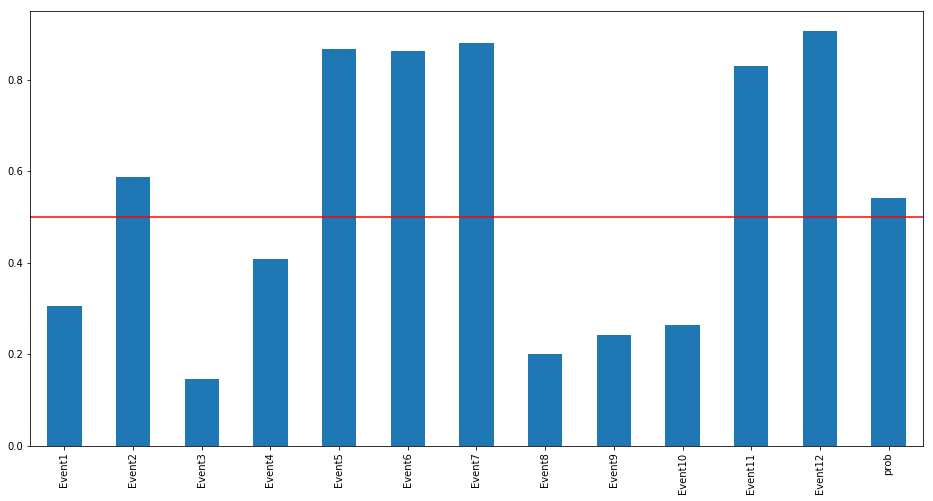

In [20]:
plt.axhline(y=0.5, color='r', linestyle='-')

df.drop('id', axis=1).mean().plot.bar();


График корреляции событий, постоенный ниже, говорит о том, что в выборке нет сильнокоррелированных событий (максимальный коэффициент равен 0.41). Так как события у нас бинарные и некторые события имеют либо очень много 1, либо очень мало, то подобные коэффициенты могут быть случайны.

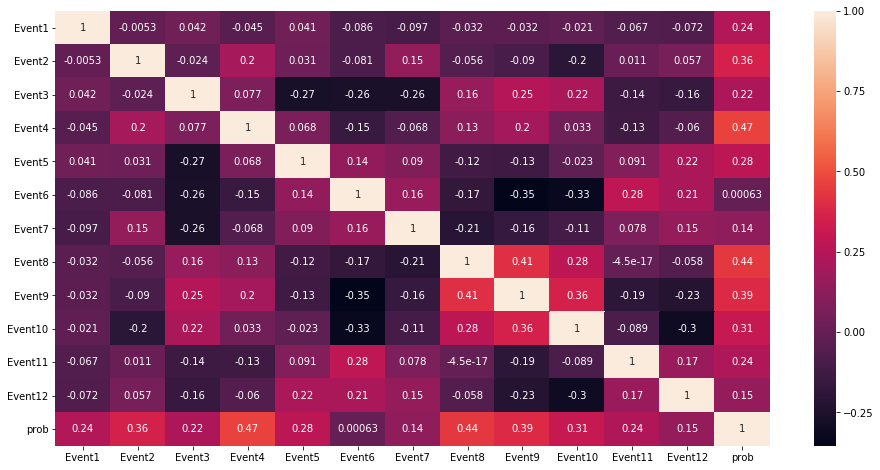

In [21]:

sns.heatmap(df.drop('id', axis=True).corr(method='pearson'), annot=True)

На графике ниже видно, что игроков, угадывающих экстримально часто или экстремально редко единицы. Большинство игроков правильно прогнозируют 6-7 раз из 12. Очевидно, что центр распределения смещен и располагается в значении 0.54 (что подтверждают расчеты), стандартное отклонение равняется 0.11. Построив на графике вертикальные красные линии с шагом std, видно, что только 8 значений из 235 выходит за эти пределы. Из этого следует, что распределение стремится к нормальному. 

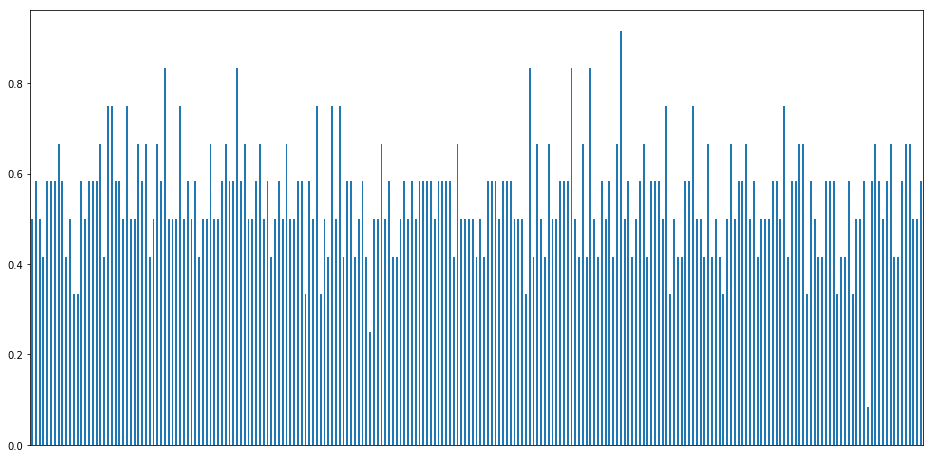

In [22]:
plt.tick_params(bottom=False, labelbottom=False)
df.drop('id', axis=1).mean(axis=1).plot.bar();

In [6]:
df.drop('id', axis=1).mean(axis=1).value_counts()

0.583333    75
0.500000    70
0.416667    36
0.666667    26
0.333333    10
0.750000    10
0.833333     5
0.083333     1
0.916667     1
0.250000     1
dtype: int64

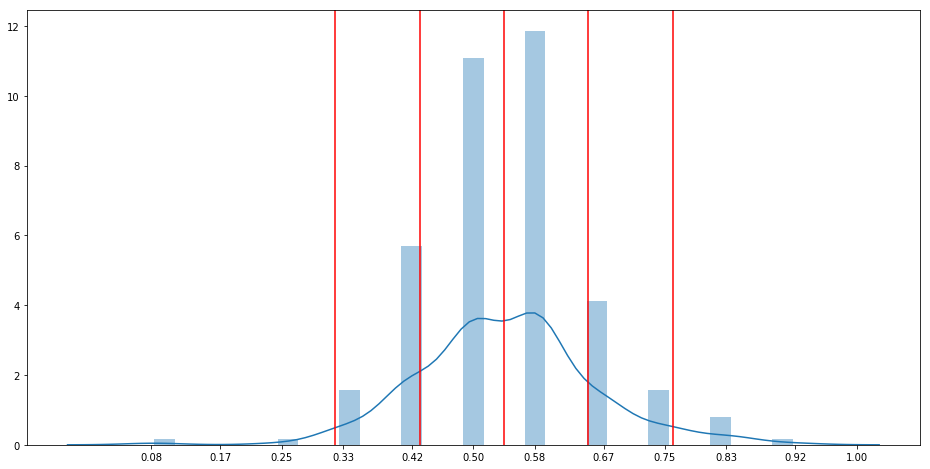

In [23]:
sns.distplot(df.drop('id', axis=1).mean(axis=1))

labels = [round(i/12, 2) for i in list(range(1, 13))]
plt.xticks(labels)
plt.axvline(x=0.54, color='r')
plt.axvline(x=0.43, color='r')
plt.axvline(x=0.65, color='r')
plt.axvline(x=0.32, color='r')
plt.axvline(x=0.76, color='r');

In [8]:
df.drop('id', axis=1).mean(axis=1).describe()

count    235.000000
mean       0.541844
std        0.112273
min        0.083333
25%        0.500000
50%        0.500000
75%        0.583333
max        0.916667
dtype: float64

In [9]:
# проверка на дубликаты строк
df.duplicated()[df.duplicated() == True]

Series([], dtype: bool)

Для использования методов кластеризации (будут ниже) и отображения графиков использовал t-SNE представление как преобразование 12-мерного пространства к 2-х мерному. Идея данного метода заключается в поиске такого преобразования, чтобы расстояние между объектами осталось пропорцианально таким же. <br/>

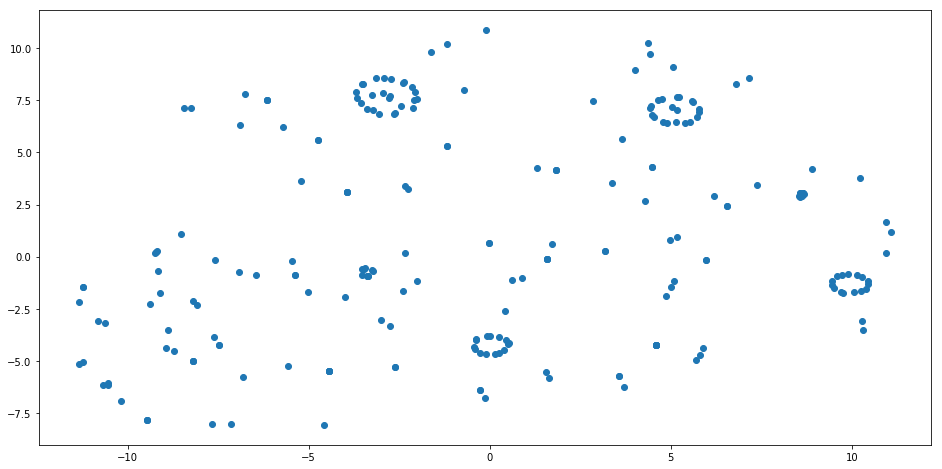

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

tsne_representation = tsne.fit_transform(df.drop('id', axis=1))

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

#### Способ 1
Один из самых простых способов разделения игроков можно провести на основе количества успешных прогнозов. Например, от 43% до 65% процентов правильных ставок. Исходя из предположение о нормальном распределении ставок, т.е. 68,2% игроков будет в этом диапозоне (правило 3 сигм) и т.д.

- 68,2% игроков в диапозоне 43-65% верных прогнозов.
- 13,6% игроков в диапозоне 32-42% верных прогнозов.
- 13,6% игроков в диапозоне 66-76% верных прогнозов.
- 2,1% игроков в диапозоне 21-31% верных прогнозов.
- 2,1% игроков в диапозоне 77-87% верных прогнозов.



In [25]:
alls = ['Event2', 'Event5', 'Event6', 'Event7', 'Event11', 'Event12', 'Event1', 'Event3', 'Event4', 'Event8', 'Event9', 'Event10']
df['prob'] = df[alls].mean(axis=1)

keys = []
for idx, i in enumerate(df['prob']):
    
    if i < 0.21: keys.append(0)
    elif i <= 0.31: keys.append(1)
    elif i <= 0.42: keys.append(2)
    elif i <= 0.65: keys.append(3)
    elif i <= 0.76: keys.append(4)
    elif i <= 0.87: keys.append(5)
    else: keys.append(0)


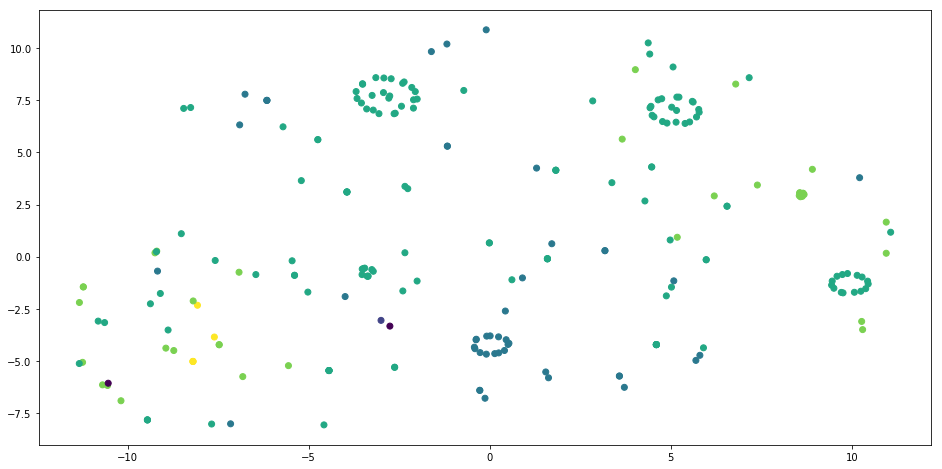

In [26]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=keys);

#### Способ 2

Разделить всех игроков на 2 группы:
- 1 - те игроки, кто выиграл половину или больше ставок на событиях, где среднее значение правильных ставок меньше половины. (переменная seldom)
- 2 - те игроки, кто проиграл больше половины ставок на сложных событиях.

Ниже график с отображением точек (желтый - 1-й класс, фиолетовый - 2-й)

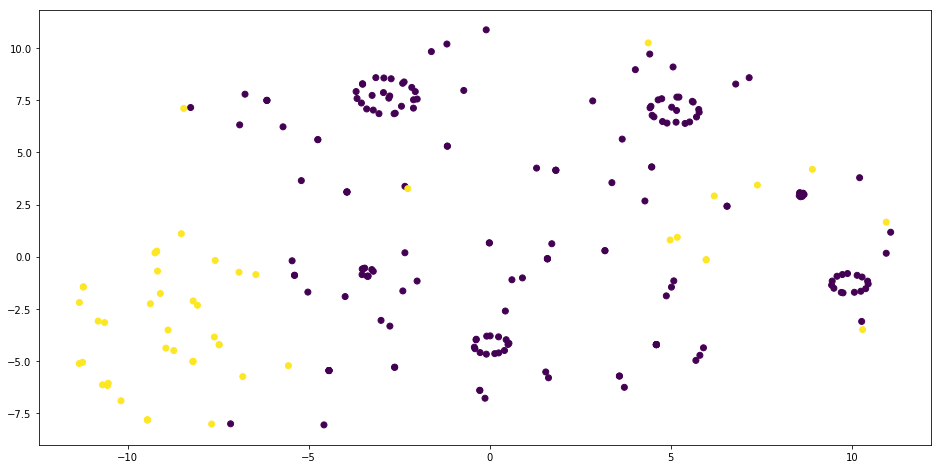

In [27]:
seldom = ['Event1', 'Event3', 'Event4', 'Event8', 'Event9', 'Event10']

# результат деления на кластеры
colors = (df[seldom].mean(axis=1) >= 0.5).map({True : 1, False : 0})
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=colors);


#### Методы кластеризации.
После использования метода преобразования и сверху методов кластеризации - интрепретируемость кластеров стирается и восстановить признаки и пороги разделения невозможно.
K-means разбил все признаки на какие-то классы.
DBSCAN и SpectralClustering - выделили несколько классов, но большинство признаков оставил без класса.


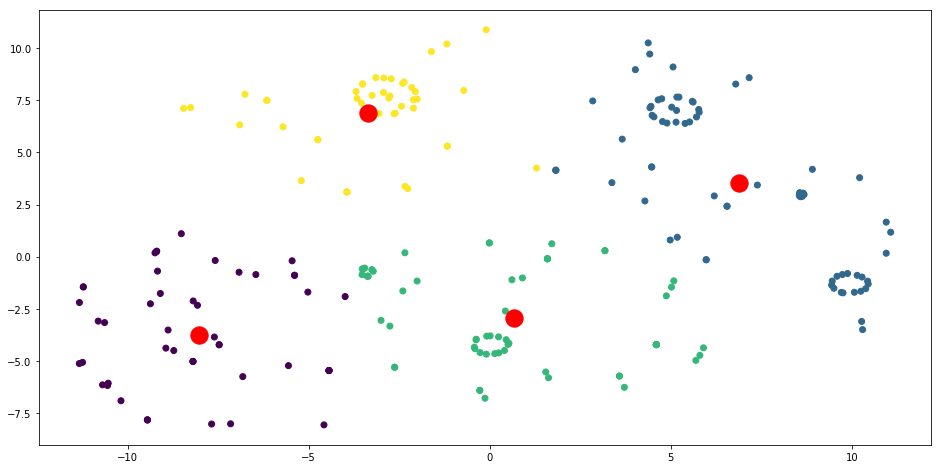

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=300, n_init=10, random_state=17)
pred_y = kmeans.fit_predict(tsne_representation)

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=pred_y)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red');


In [29]:
pred_y

array([1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1,
       3, 1, 3, 0, 0, 3, 1, 1, 1, 3, 3, 0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 3, 2, 0, 2, 2, 1, 1, 0, 0, 0, 1, 1, 0, 3, 1, 0, 3, 1, 3, 3, 0,
       2, 0, 3, 1, 1, 1, 0, 3, 3, 1, 2, 3, 2, 0, 2, 0, 3, 1, 1, 0, 3, 1,
       2, 2, 1, 0, 1, 3, 3, 2, 2, 3, 1, 3, 1, 2, 3, 0, 1, 3, 3, 0, 0, 3,
       2, 2, 0, 2, 0, 2, 3, 3, 2, 2, 1, 0, 0, 1, 3, 0, 1, 3, 3, 3, 2, 0,
       3, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2,
       1, 0, 3, 1, 2, 3, 3, 1, 3, 1, 2, 1, 1, 0, 2, 3, 2, 2, 3, 1, 0, 3,
       1, 2, 0, 2, 2, 2, 3, 2, 1, 3, 1, 0, 1, 2, 1, 2, 2, 3, 2, 3, 2, 2,
       1, 3, 0, 1, 0, 1, 2, 1, 3, 2, 3, 1, 1, 1, 2, 2, 2, 1, 3, 3, 0, 1,
       2, 0, 1, 0, 2, 1, 0, 2, 3, 0, 0, 0, 3, 2, 1])

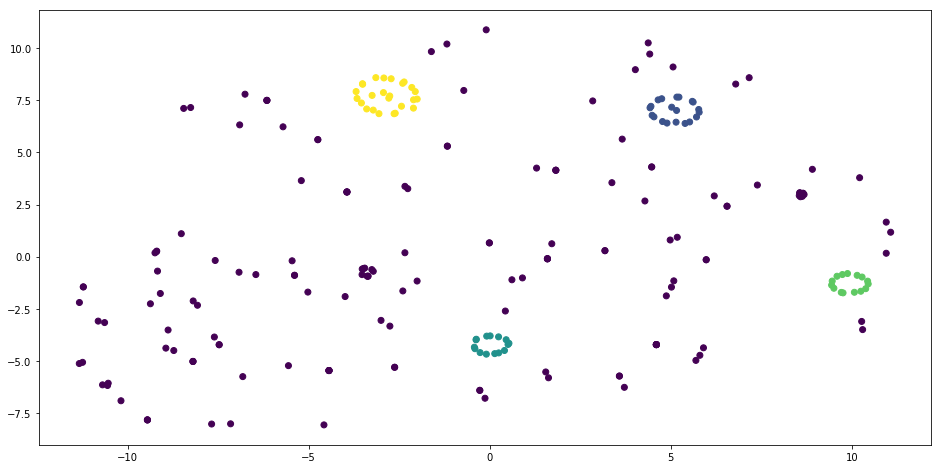

In [30]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1, min_samples=10).fit(tsne_representation)

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=clustering.labels_)

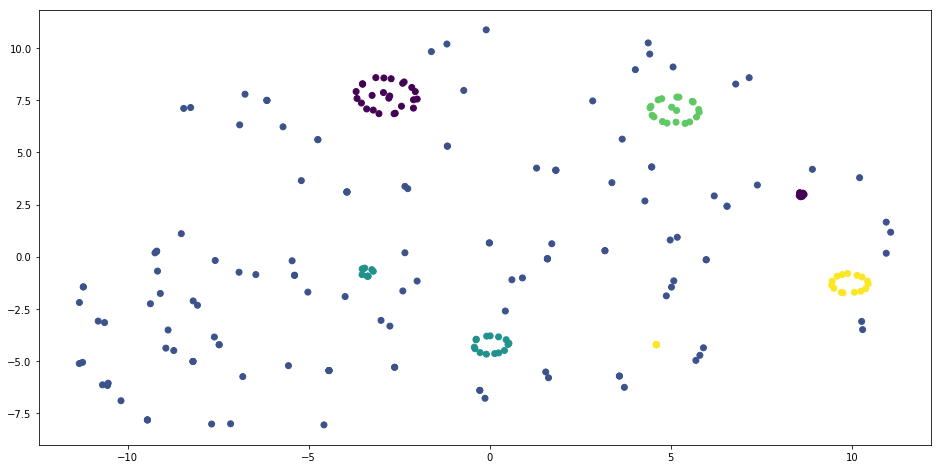

In [31]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=5).fit(df.drop('id', axis=1))

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=clustering.labels_)